# Homework 3 - CNN on Multilabel remote sensing images
## By: Syed Ali Murad Tahir

In this homework we will be performing CNN on UCMerced dataset. This dataset contains Multispectral images. 


The task is divided into following step

1)  Prepairing data
2) The data we get, we divide that data, into training, test and validation. We divide training data into training and test
3) To pretrain the model in order to avoid overfitting, we can use pretrained data already provided to us. Or, we can perform data augmentation
to pre train the data so we have more samples of data
4) Now we perform Convolution. So we choose the number of layers, neuron in that layer and the activation function of that layer (Check if need to perform padding before,). For padding check the following link: https://www.youtube.com/watch?v=mTVf7BN7S8w&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=27
5) Then we add Max pooling to take out dominant features
6) We can add dropout
7) Then we have to perform flatten the data
8) We can add a desne layer (Check if we need it or not) -> These are actually the hidden layers we specify when performing forward propgation
9) Then we train or data
10) After that we check our results on test data to check for overfitting
11) At the end we check validation




## Understanding the dataset

This is a 21 class land use image dataset meant for research purposes. However, for multilabel, we only have 17 labels

There are 100 images for each of the following classes:
    
    
 1) airplane	
 2) bare-soil	
 3) buildings	
 4) cars	
 5) chaparral	
 6) court	
 7) dock	
 8) field	
 9) grass	
 10) mobile-home	
 11) pavement	
 12) sand	
 13) sea	
 14) ship	
 15) tanks	
 16) trees	
 17) water

Each image measures 256x256 pixels.



## Imporint Libraries

In [106]:
import copy
import os
import numpy as np
import pandas as pd
import zipfile
from simple_downloader import download
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader

## Importing Dataset

In [ ]:
download_dir = Path("./Hw3_data")
download_dir.mkdir(exist_ok=True)

In [ ]:
TUB_URL = "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip"
output_file = download(TUB_URL, "./Hw3_data/")

In [ ]:
zipf = zipfile.ZipFile(output_file)
zipf.extractall(path="Hw3_data")

## Visualizing our Dataset

In [4]:
#Go to different file directory
path = os.path.join("/notebooks", "Hw3_data", "UCMerced_LandUse", "multilabels", "")
os.chdir(path)




# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))


data = pd.DataFrame(pd.read_excel("LandUse_Multilabeled.xlsx"))
data

Current working directory: /notebooks/Hw3_data/UCMerced_LandUse/multilabels


,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,agricultural00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,agricultural01,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,agricultural02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,agricultural03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,agricultural04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,tenniscourt95,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
2096,tenniscourt96,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2097,tenniscourt97,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2098,tenniscourt98,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,0


            Number of labels
airplane                 100
bare-soil                718
buildings                691
cars                     886
chaparral                115
court                    105
dock                     100
field                    103
grass                    975
mobile-home              102
pavement                1300
sand                     294
sea                      100
ship                     102
tanks                    100
trees                   1009
water                    203


Text(0.5, 1.0, 'Total no. of labels that belong to each class')

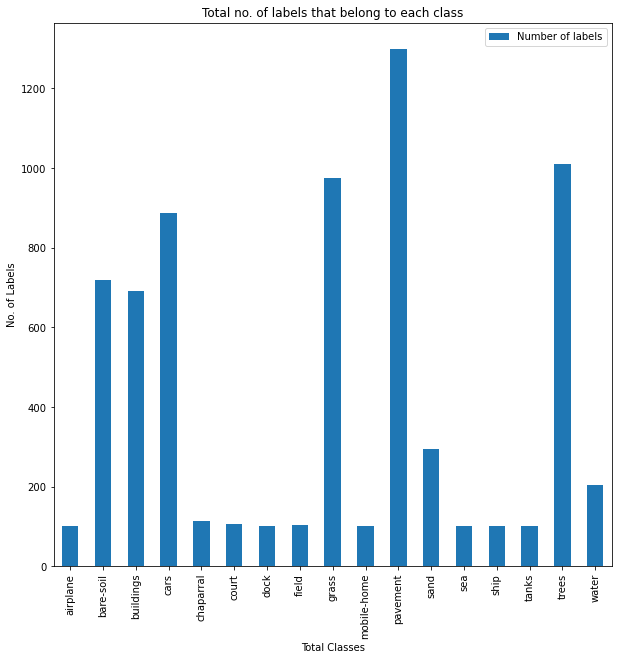

In [7]:
result = data.sum(axis="rows")
df = pd.DataFrame(result,columns=['Number of labels'])   #Convert into Data Frame
#Drop the first row
df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)
print(df)


df.plot.bar(figsize=(10,10))
plt.xlabel("Total Classes")
plt.ylabel("No. of Labels")
plt.title("Total no. of labels that belong to each class")

## Designing Data Pipeline


In [12]:
class UCMerced(Dataset):
    def __init__(self, root_dir, img_transform=None, multilabel=True):

        self.root_dir = root_dir
        self.images_path = os.path.join(root_dir, "Images")
        self.class_names = sorted(
            [cl for cl in os.listdir(self.images_path) if not cl.startswith(".")]
        )
        self.img_paths, self.img_labels = self.init_dataset()
        self.img_transform = img_transform

        if multilabel:
            self.img_labels = self.read_multilabels()  # important for loss calculation
            self.img_labels = self.img_labels.astype(float)

    def init_dataset(self):
        img_paths, img_labels = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = os.path.join(self.images_path, cl_name)

            for img in sorted(os.listdir(cl_path)):
                img_path = os.path.join(cl_path, img)
                img_paths.append(img_path)
                img_labels.append(cl_id)

        return img_paths, img_labels

    def read_multilabels(self):
        label = pd.read_excel("./Hw3_data/UCMerced_LandUse/multilabels/LandUse_Multilabeled.xlsx")
        label = label.set_index("IMAGE\LABEL")
        label = np.array(label)
        return label

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return dict(img=img, label=label)

    def __len__(self):
        return len(self.img_paths)

In [13]:
class MetricTracker(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def get_device(cuda_int):
    """Get Cuda-Device. If cuda_int < 0 compute on CPU."""
    if cuda_int < 0:
        print("Computation on CPU")
        device = torch.device("cpu")
    elif torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(cuda_int))
        device = torch.device("cuda:{}".format(cuda_int))
    return device

In [15]:
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
from torchvision.models import ResNet18_Weights
from torch.optim import Adam

def get_dataset(root_dir, tr_transform,seed=1, multilabel=True):
    valid_no = int(2100*0.1)
    train_no = int(2100*0.7) 
    test_no = int(2100*0.2)
    
    """
    Parameter
    ---------
    root_dir     : path to UCMerced Dataset
    tr_transform : transformation for training data
    te_transform : transformation for training data
    set_sizes    : list of percentage of either train-test or train-val-test (sum to 100)

    Output
    ------
    sets for train and test, optionally also val if len(set_sizes)==3
    """
    ucm_dataset_tr = UCMerced(root_dir, img_transform=tr_transform, multilabel=multilabel)
    #ucm_dataset_te = UCMerced(root_dir, img_transform=te_transform, multilabel=multilabel)
    
    trainset ,validset, testset  = random_split(ucm_dataset_tr, [train_no, valid_no, test_no])
    
    return trainset ,validset, testset
    
    
    #idx_list = split_ucm_indices(set_sizes, seed=seed)

   # train_set = Subset(ucm_dataset_tr, idx_list[0])
    #test_set = Subset(ucm_dataset_te, idx_list[-1])

    #if len(idx_list) > 2:
     #   val_set = Subset(ucm_dataset_te, idx_list[1])
      #  return train_set, val_set, test_set
    #else:
     #   return train_set, test_set

In [17]:
#Create class labels
classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]

import os
os.chdir("/notebooks")
os.getcwd()

'/notebooks'

# Training Design

In this part, we will be creating a CNN. In order to perform CNN, we had to perform the following tasks: 
1) Divide our data into training, test and validation. We use 70% data for training, 20% for testing and 10% for validation. 
2) We create the Convolution layer. In this case we use the pytorch pretrained resnet 18 model 
3) For criterion, we use a BCEWithLogitsLoss function. This is due to the fact that we want to perform multilabel classification 
4) For optimizer, we use Adam optimizer. It is the same as stochastic gradient descent 
5) We create a dense layer that used for training the model 
6) We evaluate the model in order to check whether the model is overfitting or underfitting 
7) Test the model for unseen data


In the first part, we divide our dataset into training test and validation. We provide 70% data to training, 10% to validation and 20% to testing. We already splitted the data randomly in the function get_dataset

In [19]:
#Choose our device
cuda_device = get_device(0)

Computation on CUDA GPU device 0


In [20]:
#Choose our parameter
batch_size = 64
learning_rate = 0.001
epochs = 20

In [21]:
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]

#So we resize the images so all image have same size
#This is how we transform all images

#We do it for both training and testing data
#For further understanding, pls refer to the following webste: https://www.programcreek.com/python/example/104832/torchvision.transforms.Compose

tr_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

te_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)

In [22]:
#Split data into train, validation and test
trainset, valset, testset = get_dataset(
    "./Hw3_data/UCMerced_LandUse",
    tr_transform=tr_transform,
    multilabel=True
)

In [23]:

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Define our Model

In [24]:

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 17) #21 - number of classes
model.to(cuda_device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define our criterion and gradient descent as stochastic gradient descent

In [25]:
import torch.optim as optim
from torch.optim import lr_scheduler


#Criterion
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
#criterion = nn.CrossEntropyLoss()




# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

## Define functions for training and validation

In [117]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, early_stop=False):
    train_losses, val_losses = [], []
    accuracy_scores = []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in range(1, epochs + 1):

        print("Epoch {}/{}".format(epoch, epochs))
        print("-" * 10)

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, report, _ = val_epoch(model, val_loader, criterion, device)
        overall_acc = report["accuracy"]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_scores.append(overall_acc)

        if best_acc < overall_acc:
            best_acc = overall_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch > 10 and early_stop:
            break

    return best_model, train_losses, val_losses, accuracy_scores

In [118]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.train()

    tqdm_bar = tqdm(train_loader, desc="Training: ")
    for batch in tqdm_bar:

        images = batch["img"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)
        #loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()

        probs = F.softmax(logits, dim=1)
        loss_tracker.update(loss.item(), batch_size)

        _, predicted = torch.max(probs.data, 1)
        #batch_acc = (predicted == labels).sum().item() / batch_size
        #acc_tracker.update(batch_acc, batch_size)
        tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)
        tqdm_bar.set_postfix(loss=loss_tracker.avg)

    return loss_tracker.avg

In [134]:
def val_epoch(model, val_loader, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.eval()

    y_pred = []
    y_true = []
    y_prediction_normalize = []
    y_pred_segmented = []
    classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]
    
    

    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc="Validation: ")
        for batch in tqdm_bar:

            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            batch_size = images.size(0)

            logits = model(images)
            probs = F.softmax(logits, dim=1)
            loss = criterion(logits, labels)
            loss_tracker.update(loss.item(), batch_size)

            #_, predicted = torch.max(probs.data, 1)
            predicted_prob, predicted_labels = torch.topk(probs.data, 17) #Find values fo all classes
           # batch_acc = (predicted == labels).sum().item() / batch_size
            #acc_tracker.update(batch_acc, batch_size)
            acc_tracker.update(batch_size)

            y_pred += predicted_labels.tolist()
            y_true += labels.tolist()
            tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)
            
            y_pred_arr = np.array(y_pred)
            y_true_arr = np.array(y_true)
            
            # We can normalize the y_prediction values between 0 & 1

            
            y_prediction_normalize  = normalization(y_pred_arr)
            
            
            """
            min_val = np.amin(y_pred_arr)
            max_val = np.amax(y_pred_arr)
            for i in y_pred_arr:
                for j in i:
                    z = ((y_pred_arr[j] - min_val)/ (max_val -min_val))
                y_prediction_normalize.append(z)

            y_prediction_normalize = np.array(y_prediction_normalize)
            print(y_prediction_normalize)
            print(y_prediction_normalize.shape)
            
           """         
            
            
            # Now we perform segmentation. Values > 0.5 -> 1 while other -> 0
            
            y_pred_segmented = np.where(y_prediction_normalize > 0.5, 1, 0) 
            y_pred_segmented = np.array(y_pred_segmented)
            
    print(y_pred_segmented)
    print(y_pred_segmented.shape)
      
     
    #Classfication_report and Multilabel confusion matrix
    
    report = classification_report(y_true, y_pred_segmented,target_names=classLabels)
    #report = classification_report(y_true, y_pred_segmented, zero_division=0, output_dict=True)
    conf_mat = multilabel_confusion_matrix(y_true, y_pred_segmented)
        
    return loss_tracker.avg, report, conf_mat

In [135]:
eval_accuracies = []

In [136]:
best_model, train_losses, val_losses, accuracy_scores = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=3,
    device=cuda_device,
)
eval_accuracies.append(accuracy_scores)

Epoch 1/3
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

[[1 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 1 0 1]
 [0 1 1 ... 0 1 0]
 [0 1 0 ... 1 1 0]]
(210, 17)


TypeError: string indices must be integers

In [78]:
#Testing val_epoch to test results
#Check the following link: https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/9

def val_epoch(model, val_loader, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.eval()

    y_pred = []
    y_true = []
    y_prediction_normalize = []
    y_pred_segmented=[]
    classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]
    

    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc="Validation: ")
        for batch in tqdm_bar:

            images = batch["img"].to(device) #Array of images
            labels = batch["label"].to(device) #Array of labels
            batch_size = images.size(0)

            logits = model(images)
            probs = F.softmax(logits, dim=1)
            loss = criterion(logits, labels)
            
            loss_tracker.update(loss.item(), batch_size)
            predicted_prob, predicted_labels = torch.topk(probs.data, 17)
            #predicted_prob, predicted_labels = torch.max(probs.data, 1)
            
            
           # batch_acc = (predicted == labels).sum().item() / batch_size
            #acc_tracker.update(batch_acc, batch_size)
            acc_tracker.update(batch_size)

            y_pred += predicted_labels.tolist()
            y_true += labels.tolist()
            
            y_pred_arr = np.array(y_pred)
            y_true_arr = np.array(y_true)
           
        
        return images, labels, y_pred_arr, y_true_arr, logits, probs, predicted_labels
          
            

In [94]:
#Idea taken from the following website: https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/Multi_Label_Model_Evaulation.ipynb#scrollTo=H8WBPN1OxXmw
# We have 210 values because our validation takes 10% of our data so we get 210 values out of 2100
im, lb, y_prediction, y_true, log, probs, pre = val_epoch(model, val_loader, criterion, cuda_device)
print("Y true values are: ", y_true)
print(y_true.shape)

print("Y prediction values are: ", y_prediction)
print(y_prediction.shape)
print("Type: ", type(y_prediction))




Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Y true values are:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]]
(210, 17)
Y prediction values are:  [[ 8  4 10 ...  5 15  1]
 [ 5  6  0 ...  7 16  1]
 [14 13 12 ... 16  4  9]
 ...
 [13  8 14 ... 16  1 15]
 [ 0  8 12 ...  1  4 16]
 [13  6  8 ...  2  4 15]]
(210, 17)
Type:  <class 'numpy.ndarray'>


In [113]:
# We can normalize the y_prediction values between 0 & 1



def normalization(arr: np.array) -> np.array:
    norm = []
    min_val = np.amin(arr)
    max_val = np.amax(arr)
    
    for i in arr:
        for j in i:
            z = ((arr[j] - min_val)/ (max_val -min_val))
        norm.append(z)

    norm = np.array(norm)
    
    return norm


y_prediction_normalize  = normalization(y_prediction)
print(y_prediction_normalize)
print(y_prediction_normalize.shape)


[[0.3125 0.375  0.     ... 0.4375 1.     0.0625]
 [0.3125 0.375  0.     ... 0.4375 1.     0.0625]
 [0.5    0.3125 0.75   ... 0.125  0.9375 0.0625]
 ...
 [0.3125 0.375  0.625  ... 0.0625 1.     0.4375]
 [0.8125 0.5    0.375  ... 0.5625 0.9375 1.    ]
 [0.3125 0.375  0.625  ... 0.0625 1.     0.4375]]
(210, 17)


In [91]:
# Now we perform segmentation. Values > 0.5 -> 1 while other -> 0


y_pred_segmented=[]

y_pred_segmented = np.where(y_prediction_normalize > 0.5, 1, 0) 

y_pred_segmented = np.array(y_pred_segmented)
print(y_pred_segmented)
print(y_pred_segmented.shape)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(210, 17)


In [46]:
# Create a confusion matrix:
from sklearn.metrics import multilabel_confusion_matrix, f1_score, average_precision_score
st = multilabel_confusion_matrix(y_true, y_pred_segmented)


classLabels = ["airplane", "bare-soil", "buildings", "cars","chaparral", "court", "dock", "field", "grass", "mobile-home","pavement","sand", "sea","ship",
               "tanks", "trees", "water"]

#Classifcation report
#Check the following link to understand all the column: https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404
M = classification_report(y_true, y_pred_segmented,target_names=classLabels)
print(M)

              precision    recall  f1-score   support

    airplane       0.03      0.25      0.05         4
   bare-soil       0.71      0.08      0.14        63
   buildings       0.32      0.93      0.47        67
        cars       0.47      0.55      0.51        89
   chaparral       0.03      0.50      0.05         6
       court       0.06      0.64      0.10        11
        dock       0.04      0.64      0.07        11
       field       0.02      0.17      0.04        12
       grass       0.44      0.75      0.56        93
 mobile-home       0.09      0.50      0.16        14
    pavement       0.53      0.42      0.47       133
        sand       0.04      0.03      0.03        34
         sea       0.05      0.70      0.10        10
        ship       0.04      0.55      0.08        11
       tanks       0.04      0.50      0.08         6
       trees       0.51      0.49      0.50       112
       water       0.08      0.04      0.06        24

   micro avg       0.20   

In [45]:
#f1-score micro

f1_score(y_true, y_pred_segmented, labels=classLabels, average='micro')


UFuncTypeError: ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

ValueError: Must pass 2-d input. shape=(17, 2, 2)

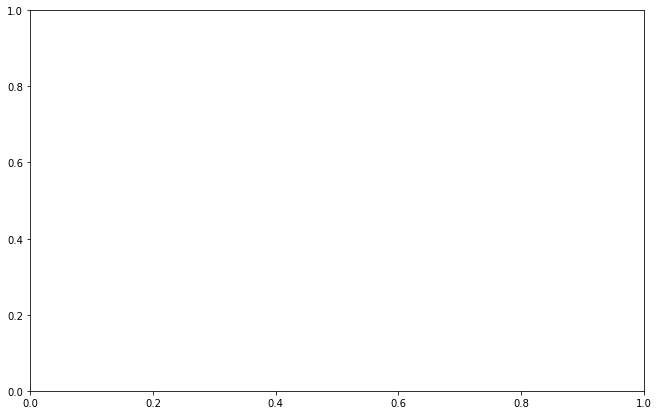